# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Problem Statement
The problem is Starbucks give each customer an offer, but there are some customers didn't use the offer or didn't view the offer. So I would like to make an analysis of Starbucks datasets to find which kind of people or their demography have an offer and they completed the offer. This people should have attention to send to them offers. Also, I want to find out which kind of offer (BOGO or Discount or Informational) do people more like or use more.The solution will reduce the overhead cost of sending offers to any customer. For that, I will use accuracy metric to evaluate some supervised learning models.

# Business Understanding

In this project, I will analyse the datasets provided by answering these questions  which help to make a decision to solve the problem with visualizations and modeling the dataset:
* Q1: What is the distribution of gender?
* Q2: What is the distribution of income by gender?
* Q3: What are the most and the least common event?
* Q4: What are the most and the least common offer type?
* Q5: What are the most and the least common offer type by offer completed?
* Q6: What is the distribution of gender by offer type?
* Q7: What is the distribution of gender by event?

Then, I will calculate the accuracy metrics for some of the models on the training and testing datasets and improve the best one. I selected accuracy due to the target variable classes in the data and I want to find out the ratio of the total number of predictions that were correct. <br>

In [158]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

import seaborn as sns

# Data Understanding

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [102]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration
In order to analyze the problem better in next sections, first we need to explore the datasets which includes checking the missing value, visualizing the data distribution, etc. In that way, we can have a better understanding on how the dataset looks like and how we cam featurize the data to make it ready for modeling

## Portfolio dataset 

In [103]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [104]:
portfolio.shape

(10, 6)

In [105]:
portfolio.id.nunique()

10

We have 10 different offers in the portfolio and it might be useful to separate the channels into different columns.

In [106]:
#convert the channels column into one-hot encoded feature
dict_channels = ['web', 'email', 'mobile', 'social']
channels = portfolio.channels.apply(lambda row:pd.Series([1 if i in row else 0 for i in dict_channels]))
portfolio[dict_channels] = channels
portfolio.drop(columns='channels', inplace=True)

In [107]:
portfolio

,reward,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [108]:
# Offers of each type
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

There are 3 types of offers : BOGO, Discount and Informational

In [109]:
portfolio = portfolio.join(pd.get_dummies(portfolio.offer_type))

In [110]:
portfolio

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


### Profile dataset

In [111]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [112]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [113]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [114]:
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99], dtype=int64)

In [115]:
profile.groupby('age').count().tail(10)

,gender,id,became_member_on,income
age,,,,
93,29,29,29,29
94,33,33,33,33
95,22,22,22,22
96,8,8,8,8
97,13,13,13,13
98,5,5,5,5
99,5,5,5,5
100,12,12,12,12
101,5,5,5,5


In [116]:
#Age Column
profile[profile.age == 118][['gender','age','income']]

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
...,...,...,...
16980,None,118,NaN
16982,None,118,NaN
16989,None,118,NaN
16991,None,118,NaN


As we can observe that age value is 118 for all columns where null value is there in gender and income and hence we can directly drop and clean these rows.

In [117]:
profile.duplicated().sum()

0

In [118]:
age_118 = profile[profile['age'] == 118]

In [119]:
age_118.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            0 non-null      object 
 1   age               2175 non-null   int64  
 2   id                2175 non-null   object 
 3   became_member_on  2175 non-null   int64  
 4   income            0 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


We can see that all the users with age 118 have no data in the gender and income columns.
We will see if they have interactions with the offers.

### Transcript table

In [120]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [121]:
transcript.shape

(306534, 4)

In [122]:
# quick check on missing value
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [123]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [124]:
transcript.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714], dtype=int64)

In [125]:
transcript[transcript['person'].isin(age_118.id)].shape

(33772, 4)

About 10 percent of the interactions of users with offers are made by non well identified users (118 years old). This data might still be useful for general behaviour analysis, but since we will focus into demographic factors let's drop all the users and interactions for the 118 years old.

In [126]:
transcript = transcript[~transcript['person'].isin(age_118.id)]
transcript.shape

(272762, 4)

In [127]:
profile = profile[profile['age'] < 118]
profile.shape

(14825, 5)

In [128]:
# Offer id is the same like offer_id
# So I will create one column for each values of value column by using iterrows()
# It seem like one_hot encoding
transcript['offer_id'] = ''
transcript['amount'] = 0
transcript['reward'] = 0

for x, row in transcript.iterrows():
    for f in row['value']:
        if f == 'offer_id' or f == 'offer id':
            transcript.at[x, 'offer_id']= row['value'][f]
        if f == 'amount':
            transcript.at[x, 'amount']= row['value'][f]
        if f == 'reward':
            transcript.at[x, 'reward']= row['value'][f]

# Drop the value column in transcript dataset
transcript = transcript.drop('value', axis=1)

# Print 3 first rows of transcript dataset
transcript.head(3)

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,0
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0


# Data Modeling

* Q1: What is the distribution of gender?
* Q2: What is the distribution of income by gender?
* Q3: What are the most and the least common event?
* Q4: What are the most and the least common offer type?
* Q5: What are the most and the least common offer type by offer completed?
* Q6: What is the distribution of gender by offer type?
* Q7: What is the distribution of gender by event?

### Q1: What is the distribution of gender?

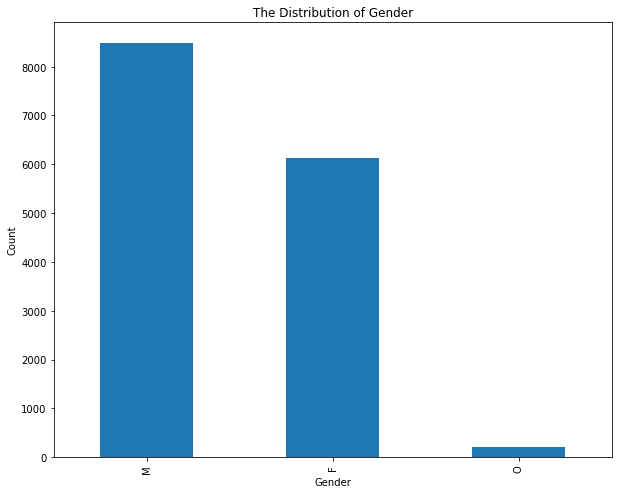

In [129]:
# Create a Bar chart for the distribution of gender
profile['gender'].value_counts().plot(kind='bar', figsize = (10,8))
plt.title('The Distribution of Gender')
plt.ylabel('Count')
plt.xlabel('Gender');

In [130]:
profile.gender.describe()

count     14825
unique        3
top           M
freq       8484
Name: gender, dtype: object

### Q2: What is the distribution of income by gender?

C:\Users\dursuny\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\dursuny\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


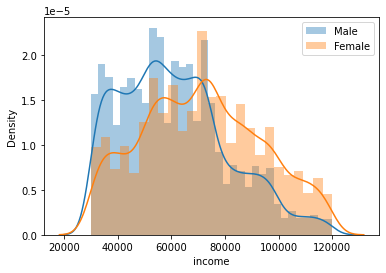

In [131]:
# Gender-wise Income Distribution
sns.distplot(profile[profile.gender=='M'].income,label='Male')
sns.distplot(profile[profile.gender=='F'].income,label='Female')
plt.legend()
plt.show()

In [169]:
# Print describe details of gender
profile.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [170]:
# Print the descriptive statistics of income by gender
income_gender = profile.groupby('gender')['income']
income_gender.describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,6129.0,71306.412139,22338.353773,30000.0,54000.0,71000.0,88000.0,120000.0
M,8484.0,61194.601603,20069.517615,30000.0,45000.0,59000.0,73000.0,120000.0
O,212.0,63287.735849,18938.594726,30000.0,51000.0,62000.0,79250.0,100000.0


### Q3: What are the most and the least common event?

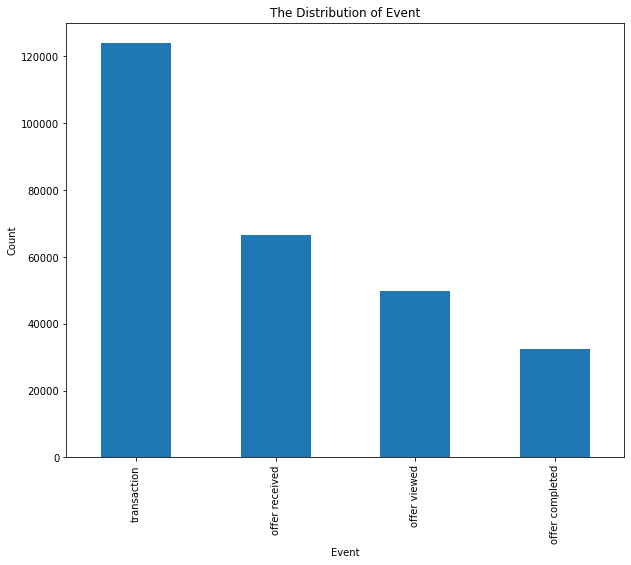

In [132]:
# Create a Bar chart for event
transcript['event'].value_counts().plot(kind='bar', figsize = (10,8))
plt.title('The Distribution of Event')
plt.ylabel('Count')
plt.xlabel('Event');

### Q4: What are the most and the least common offer type?

In [133]:
transcript.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,0
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0


In [134]:
# Get offer_type from Portfolio dataset to Transcript dataset
# by matching id column in Portfolio with offer_id column in Transcript
def get_offer_type(offer_id):
    try:
        offer_type = portfolio[portfolio['id'] == offer_id]['offer_type'].values[0]
        return offer_type
    except:
        offer_type = 'NA'
        return offer_type

# Create a new column in Transcript dataset named offer_type
transcript['offer_type'] = transcript.apply(lambda x: get_offer_type(x['offer_id']), axis=1)

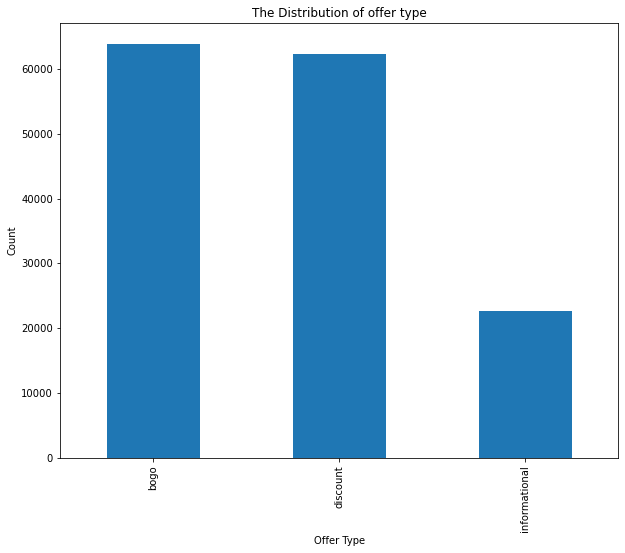

In [171]:
# Create a box plot for offer type without NA type
transcript[transcript['offer_type'] != 'NA']['offer_type'].value_counts().plot(kind = 'bar', figsize = (10,8))
plt.title('The Distribution of offer type')
plt.ylabel('Count')
plt.xlabel('Offer Type');

In [136]:
transcript.offer_type.value_counts()

NA               123957
bogo              63834
discount          62311
informational     22660
Name: offer_type, dtype: int64

### Q5: What are the most and the least common offer type by offer completed?

The Most Offer Type For Customers Who Completed Offer Is: discount
Number of Customers: 17186
Offer Id: 5003
-----------------
The Least Offer Type For Customers Who Completed Offer Is: bogo
Number of Customers: 15258
Offer Id: 3310


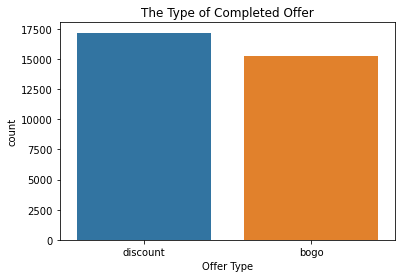

In [137]:
# I selected type of event which is offer_completed
# To see which offer type was used by customers.
offer_completed_type = transcript[transcript['event'] == 'offer completed']

# Create a bar plot 
sns.countplot(x=offer_completed_type['offer_type'])
plt.title('The Type of Completed Offer')
plt.xlabel('Offer Type');

# Print offer type name which is the most offer type used
print(f'The Most Offer Type For Customers Who Completed Offer Is: {offer_completed_type["offer_type"].value_counts().index[0]}')

# Print Number of Customers for the most offer type used
print(f'Number of Customers: {offer_completed_type["offer_type"].value_counts().values[0]}')

# Print offer id for the most offer type used
print(f'Offer Id: {offer_completed_type["offer_id"].value_counts().values[0]}') 

print('-----------------')

# Print offer type name which is the least offer type used
print(f'The Least Offer Type For Customers Who Completed Offer Is: {offer_completed_type["offer_type"].value_counts().index[-1]}')

# Print Number of Customers for the least offer type used      
print(f'Number of Customers: {offer_completed_type["offer_type"].value_counts().values[-1]}')

# Print offer id for the least offer type used      
print(f'Offer Id: {offer_completed_type["offer_id"].value_counts().values[-1]}')

### Q6: What is the distribution of gender by offer type?

In [138]:
# Get gender from Profile dataset to Transcript dataset
# Create get_customer_gender function for that and return gender
def get_customer_gender(profile_id):
    gender = profile[profile['id'] == profile_id]['gender'].values[0]
    return gender

# Create a new column in Transcript dataset named gender
transcript['gender'] = transcript.apply(lambda x: get_customer_gender(x['person']), axis=1)

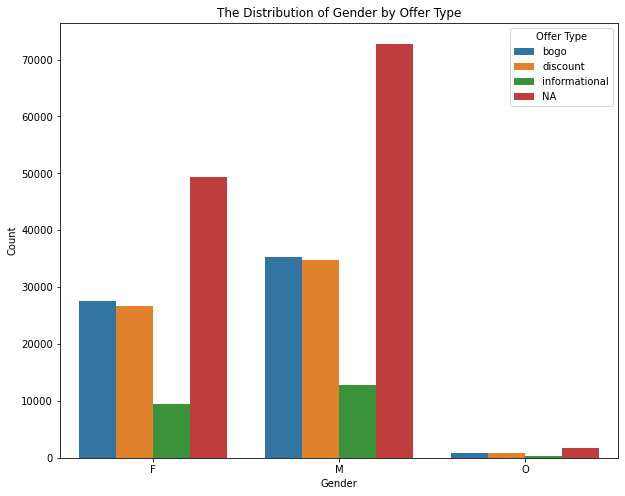

In [139]:
# Create a box plot for gender without NA type of gender by offer type
plt.figure(figsize=(10, 8))
sns.countplot(x=transcript[transcript["gender"] != 'NA']['gender'], hue="offer_type", data=transcript)
plt.title('The Distribution of Gender by Offer Type')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.legend(title='Offer Type')

In [140]:
# Exact numbers of transcript for gender (without NA) by each of offer type
gender_by_offer_type = transcript[transcript["gender"] != 'NA'].groupby(['gender','offer_type']).count()
gender_by_offer_type

person  event   time  offer_id  amount  reward
gender offer_type                                                   
F      NA              49382  49382  49382     49382   49382   49382
       bogo            27619  27619  27619     27619   27619   27619
       discount        26652  26652  26652     26652   26652   26652
       informational    9448   9448   9448      9448    9448    9448
M      NA              72794  72794  72794     72794   72794   72794
       bogo            35301  35301  35301     35301   35301   35301
       discount        34739  34739  34739     34739   34739   34739
       informational   12856  12856  12856     12856   12856   12856
O      NA               1781   1781   1781      1781    1781    1781
       bogo              914    914    914       914     914     914
       discount          920    920    920       920     920     920
       informational     356    356    356       356     356     356

In [141]:
# Count number of female transcript 
female_offer_type = gender_by_offer_type.loc[('F')]['event'].sum()

# Count number of female transcript for each type of offer types 
total_female_offer_type = gender_by_offer_type.loc[('F')].loc[['bogo', 'discount', 'informational']]['event'].sum()

# Print Female Transcripts Numbers
print(f'The Female Transcripts Number = {female_offer_type}')

# Print The Proportion of BOGO Offers for female
print(f"The Proportion of BOGO Offers =  {round((gender_by_offer_type.loc[('F', 'bogo')].values[0]/total_female_offer_type)*100,2)}% ")

# Print The Proportion of Discount Offers for female      
print(f"The Proportion of Discount Offers = {round((gender_by_offer_type.loc[('F', 'discount')].values[0]/total_female_offer_type)*100,2)}% ")

# Print The Proportion of Informational Offers for female      
print(f"The Proportion of Informational Offers = {round((gender_by_offer_type.loc[('F', 'informational')].values[0]/total_female_offer_type)*100,2)}% ")

print('----------------------')
      
# Count number of male transcript
male_offer_type = gender_by_offer_type.loc[('M')]['event'].sum()
      
# Count number of male transcript for each type of offer types
total_male_offer_type = gender_by_offer_type.loc[('M')].loc[['bogo', 'discount', 'informational']]['event'].sum()

# Print male Transcripts Numbers
print(f'The Male Transcripts Number = {male_offer_type}')

# Print The Proportion of BOGO Offers for male
print(f"The Proportion of BOGO Offers =  {round((gender_by_offer_type.loc[('M', 'bogo')].values[0]/total_male_offer_type)*100,2)}% ")

# Print The Proportion of Discount Offers for male      
print(f"The Proportion of Discount Offers = {round((gender_by_offer_type.loc[('M', 'discount')].values[0]/total_male_offer_type)*100,2)}% ")

# Print The Proportion of Informational Offers for male      
print(f"The Proportion of Informational Offers = {round((gender_by_offer_type.loc[('M', 'informational')].values[0]/total_male_offer_type)*100,2)}% ")


The Female Transcripts Number = 113101
The Proportion of BOGO Offers =  43.34% 
The Proportion of Discount Offers = 41.83% 
The Proportion of Informational Offers = 14.83% 
----------------------
The Male Transcripts Number = 155690
The Proportion of BOGO Offers =  42.58% 
The Proportion of Discount Offers = 41.91% 
The Proportion of Informational Offers = 15.51% 


### Q7: What is the distribution of gender by event?

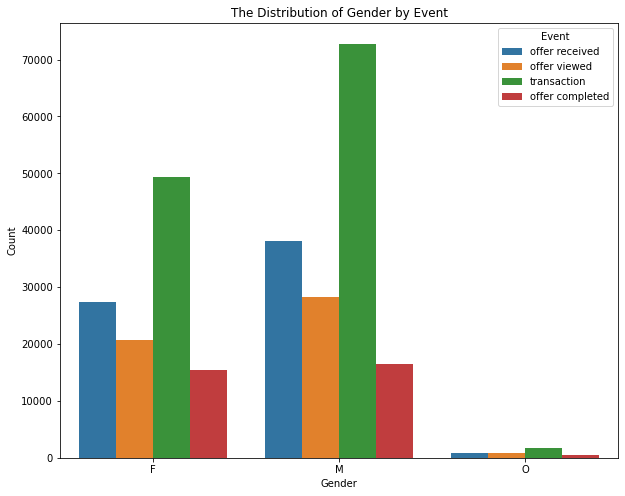

In [142]:
# Create a box plot for gender without NA type of gender by event
plt.figure(figsize=(10, 8))
sns.countplot(x=transcript[transcript["gender"] != 'NA']['gender'], hue="event", data=transcript)
plt.title('The Distribution of Gender by Event')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.legend(title='Event')

In [143]:
# To see the exact numbers of transcript for gender (without NA) by each of event type
gender_by_event_type = transcript[transcript["gender"] != 'NA'].groupby(['gender','event']).count()
gender_by_event_type

person   time  offer_id  amount  reward  offer_type
gender event                                                               
F      offer completed   15477  15477     15477   15477   15477       15477
       offer received    27456  27456     27456   27456   27456       27456
       offer viewed      20786  20786     20786   20786   20786       20786
       transaction       49382  49382     49382   49382   49382       49382
M      offer completed   16466  16466     16466   16466   16466       16466
       offer received    38129  38129     38129   38129   38129       38129
       offer viewed      28301  28301     28301   28301   28301       28301
       transaction       72794  72794     72794   72794   72794       72794
O      offer completed     501    501       501     501     501         501
       offer received      916    916       916     916     916         916
       offer viewed        773    773       773     773     773         773
       transaction        1781   1781      1781    1781    1781        1781

In [144]:
# Print Female Transcripts Numbers
print(f'The Female Transcripts Number = {female_offer_type}')

# Print The Proportion of  Offer Completed for female
print(f"The Proportion of Offer Completed Type =  {round((gender_by_event_type.loc[('F', 'offer completed')].values[0]/gender_by_event_type.loc[('F', 'offer received')].values[0])*100,2)}% of Offers Received ")

# Print The Proportion of Offer Received for female      
print(f"The Proportion of Offer Received Type = {round((gender_by_event_type.loc[('F', 'offer received')].values[0]/total_female_offer_type)*100,2)}% ")

# Print The Proportion of Offer Viewed for female      
print(f"The Proportion of Offer Viewed Type = {round((gender_by_event_type.loc[('F', 'offer viewed')].values[0]/total_female_offer_type)*100,2)}% ")

# Print The Proportion of Transaction for female      
print(f"The Proportion of Transaction Type = {round((gender_by_event_type.loc[('F', 'transaction')].values[0]/total_female_offer_type)*100,2)}% ")

print('----------------------')
      
# Print male Transcripts Numbers
print(f'The Male Transcripts Number = {male_offer_type}')

# Print The Proportion of  Offer Completed for male
print(f"The Proportion of Offer Completed Type =  {round((gender_by_event_type.loc[('M', 'offer completed')].values[0]/gender_by_event_type.loc[('M', 'offer received')].values[0])*100,2)}% of Offers Received ")

# Print The Proportion of Offer Received for male      
print(f"The Proportion of Offer Received Type = {round((gender_by_event_type.loc[('M', 'offer received')].values[0]/total_male_offer_type)*100,2)}% ")

# Print The Proportion of Offer Viewed for male      
print(f"The Proportion of Offer Viewed Type = {round((gender_by_event_type.loc[('M', 'offer viewed')].values[0]/total_male_offer_type)*100,2)}% ")

# Print The Proportion of Transaction for male      
print(f"The Proportion of Transaction Type = {round((gender_by_event_type.loc[('M', 'transaction')].values[0]/total_male_offer_type)*100,2)}% ")


The Female Transcripts Number = 113101
The Proportion of Offer Completed Type =  56.37% of Offers Received 
The Proportion of Offer Received Type = 43.09% 
The Proportion of Offer Viewed Type = 32.62% 
The Proportion of Transaction Type = 77.5% 
----------------------
The Male Transcripts Number = 155690
The Proportion of Offer Completed Type =  43.18% of Offers Received 
The Proportion of Offer Received Type = 46.0% 
The Proportion of Offer Viewed Type = 34.14% 
The Proportion of Transaction Type = 87.81% 


## Data Preprocessing

In [145]:
# Adding income column in transcript dataset may need it for model
# To get income from Profile dataset to Transcript dataset
# Create get_customer_income function for that and return income
def get_customer_income(profile_id):
    income = profile[profile['id'] == profile_id]['income'].values[0]
    return income

# Create a new column in Transcript dataset named income
transcript['income'] = transcript.apply(lambda x: get_customer_income(x['person']), axis=1)

In [146]:
# Take a look to transcript after changes
# Print a three first rows of Transcript dataset
transcript.head(3)

,person,event,time,offer_id,amount,reward,offer_type,gender,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,bogo,F,100000.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,0,discount,M,70000.0
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0,bogo,M,53000.0


In [147]:
# Save copy of Transcript into csv file to work on it
transcript.to_csv('clean_transcript.csv')

# Read 'clean_transcript.csv' file
transcript_cleaned = pd.read_csv('clean_transcript.csv').iloc[:, 1:]

# Print the first five rows of transcript_cleaned dataset
transcript_cleaned.head()

,person,event,time,offer_id,amount,reward,offer_type,gender,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,bogo,F,100000.0
1,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,0,discount,M,70000.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0,bogo,M,53000.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,0,0,informational,M,51000.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,discount,F,57000.0


In [148]:
# Check if there are any missing value in transcript_cleaned dataset
transcript_cleaned.isna().sum()

person             0
event              0
time               0
offer_id      123957
amount             0
reward             0
offer_type    123957
gender             0
income             0
dtype: int64

In [149]:
# Fill the missing value in offer_id, offer_type and gender columns with NA
transcript_cleaned['offer_id'].fillna('NA', inplace=True)
transcript_cleaned['offer_type'].fillna('NA', inplace=True)
transcript_cleaned['gender'].fillna('NA', inplace=True)

In [150]:
# To ensure there are not any missing value in transcript_cleaned dataset
transcript_cleaned.isna().sum()

person        0
event         0
time          0
offer_id      0
amount        0
reward        0
offer_type    0
gender        0
income        0
dtype: int64

In [151]:
# Print number of rows and columns of transcript_cleaned
transcript_cleaned.shape

(272762, 9)

In [152]:
# Drop offer_id with NA value due to unneeded
transcript_cleaned = transcript_cleaned[transcript_cleaned['offer_id'] != 'NA']

In [153]:
# Updated number of rows and columns of transcript_cleaned
transcript_cleaned.shape

(148805, 9)

In [154]:
# Replacing categorical values to numerical values 
# For event, offer_id, offer_type and gender cloumns

# 'offer completed'= 1, 'offer received'= 2, 'offer viewed'= 3
event_type_labels = transcript_cleaned['event'].astype('category').cat.categories.tolist()
replace_event_type = {'event' : {k: v for k,v in zip(event_type_labels,list(range(1,len(event_type_labels)+1)))}}
print(replace_event_type)
print('------------------')

# '0b1e1539f2cc45b7b9fa7c272da2e1d7'= 1, '2298d6c36e964ae4a3e7e9706d1fb8c2': 2, 
# and so on
offer_id_labels = transcript_cleaned['offer_id'].astype('category').cat.categories.tolist()
replace_offer_id = {'offer_id' : {k: v for k,v in zip(offer_id_labels,list(range(1,len(offer_id_labels)+1)))}}
print(replace_offer_id)
print('------------------')

# 'bogo'= 1, 'discount'= 2, 'informational'= 3
offer_type_labels = transcript_cleaned['offer_type'].astype('category').cat.categories.tolist()
replace_offer_type = {'offer_type' : {k: v for k,v in zip(offer_type_labels,list(range(1,len(offer_type_labels)+1)))}}
print(replace_offer_type)
print('------------------')

# 'F'= 1, 'M'= 2, 'NA'= 3, 'O'= 4
gender_labels = transcript_cleaned['gender'].astype('category').cat.categories.tolist()
replace_gender = {'gender' : {k: v for k,v in zip(gender_labels,list(range(1,len(gender_labels)+1)))}}
print(replace_gender)

{'event': {'offer completed': 1, 'offer received': 2, 'offer viewed': 3}}
------------------
{'offer_id': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1, '2298d6c36e964ae4a3e7e9706d1fb8c2': 2, '2906b810c7d4411798c6938adc9daaa5': 3, '3f207df678b143eea3cee63160fa8bed': 4, '4d5c57ea9a6940dd891ad53e9dbe8da0': 5, '5a8bc65990b245e5a138643cd4eb9837': 6, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7, 'ae264e3637204a6fb9bb56bc8210ddfd': 8, 'f19421c1d4aa40978ebb69ca19b0e20d': 9, 'fafdcd668e3743c1bb461111dcafc2a4': 10}}
------------------
{'offer_type': {'bogo': 1, 'discount': 2, 'informational': 3}}
------------------
{'gender': {'F': 1, 'M': 2, 'O': 3}}


In [155]:
# Replace these labels above in transcript_cleaned dataset
transcript_cleaned.replace(replace_event_type, inplace=True)
transcript_cleaned.replace(replace_offer_id, inplace=True)
transcript_cleaned.replace(replace_offer_type, inplace=True)
transcript_cleaned.replace(replace_gender, inplace=True)

In [156]:
# Split data into the target (offer_type) and features_final 
target = transcript_cleaned['offer_type']

# I will drop person and offer_type columns due to unneeded any more
features_final = transcript_cleaned.drop(['person', 'offer_type'], axis = 1)

In [223]:
target

0         1
1         2
2         1
3         3
4         2
         ..
272717    3
272724    3
272737    2
272739    2
272757    2
Name: offer_type, Length: 148805, dtype: int64

### Normalizing Numerical Features

In [159]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['time', 'amount', 'reward', 'income']

features_final[numerical] = scaler.fit_transform(features_final[numerical])

# Show an example of a record with scaling applied
display(features_final.head(n = 5))

,event,time,offer_id,amount,reward,gender,income
0,2,0.0,7,0.0,0.0,1,0.777778
1,2,0.0,3,0.0,0.0,2,0.444444
2,2,0.0,9,0.0,0.0,2,0.255556
3,2,0.0,4,0.0,0.0,2,0.233333
4,2,0.0,1,0.0,0.0,1,0.300000


In [160]:
# Split the 'features' and 'target' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 119044 samples.
Testing set has 29761 samples.


### Metrics
I will calculate the accuracy metrics for some of the models on the training and testing datasets and improve the best one. I selected accuracy due to the target variable classes in the data are tied and I would like to find the ratio of the total number of predictions that were correct. Then, I will evaluate this metric on some models are Support Vector Machines (SVC), Random Forest Classifier, Naive Bayes and Logistic Regression.
ROC-AUC can be a more optimal metric but it ist restricted to a binary classification task. For this our target variable has to be one hot encoded. This could be a further improvement for rating our models.
I will use default parameter values for modeling.

In [161]:
# Create a function in which predict the model and returns the accuracy
def pred_score(model):
    pred = model.predict(X_test)
    
    # Count errors
    errors = abs(pred - y_test)
    
    # Count mean percentage error
    mpe = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mpe)
    return round(accuracy, 2)

#### Support Vector Machines (SVC)

In [162]:
# Import the supervised learning model (SVC) from sklearn
from sklearn.svm import SVC

# Initialize the model
svm = SVC()

# Fit the model
svm.fit(X_train, y_train)

print(f'The Accuracy of SVC Classifier on Training Set: {round(svm.score(X_train, y_train)*100,2)}%.')
print(f'The Prediction Accuracy: {pred_score(svm)}%')

The Accuracy of SVC Classifier on Training Set: 91.6%.
The Prediction Accuracy: 94.36%


#### Random Forest Classifier

In [163]:
# Import the supervised learning model RandomForestClassifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf = RandomForestClassifier().fit(X_train, y_train)

# Fit the model
rf.fit(X_train, y_train)

print(f'The Accuracy of Random Forest Classifier on Training Set: {round(rf.score(X_train, y_train)*100,2)}%.')
print(f'The Prediction Accuracy: {pred_score(rf)}%')

The Accuracy of Random Forest Classifier on Training Set: 100.0%.
The Prediction Accuracy: 100.0%


#### Naive Bayes

In [164]:
# Import the supervised learning model Naive Bayes from sklearn
from sklearn.naive_bayes import GaussianNB 

# Initialize the model
nb = GaussianNB() 

# Fit the model
nb.fit(X_train, y_train) 

print(f'The Accuracy of Naive Bayes Classifier on Training Set: {round(nb.score(X_train, y_train)*100,2)}%.')
print(f'The Prediction Accuracy: {pred_score(nb)}%')

The Accuracy of Naive Bayes Classifier on Training Set: 50.25%.
The Prediction Accuracy: 26.24%


#### Logistic Regression

In [165]:
# Import the supervised learning model Logistic Regression from sklearn
from sklearn.linear_model import LogisticRegression

# Initialize the model
log_reg = LogisticRegression()

# Fit the model
log_reg.fit(X_train, y_train)

print(f'The Accuracy of Logistic Regression Classifier on Training Set: {round(log_reg.score(X_train, y_train)*100,2)}%.')
print(f'The Prediction Accuracy: {pred_score(log_reg)}%')

The Accuracy of Logistic Regression Classifier on Training Set: 64.54%.
The Prediction Accuracy: 79.3%


C:\Users\dursuny\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Implementation

Before evaluating the accuracy metric, I made some processing on the data to implement the metrics on it: I replaced the categorical value into a numerical value, selected the target (offer_type) and features, normalized the numerical features, split the data and implemented the metric. I created a function which predicts the model and returns the accuracy that is the ratio of the total number of predictions that were correct.

I used the following models. Support Vector Machines (SVC), Random Forest Classifier, Naive Bayes and Logistic Regression. For modeling  I used default parameter values. Support Vector Machines and Random Forest Classifier showed 100% of accuracy on the training set and testing set. The reason for this is over-fitting. The Naive Bayes model showed the lowset of accuracy in the training set and on the testing set. The Logistic Regression showed a reasonable result which is 65.45% on the training set and 80.73% on the testing set. So, I prefer to choose this model and evaluate some of the parameters to make improvement.

### Model Improvement and Evaluation

In [167]:
from sklearn.model_selection import GridSearchCV

# Defining new parameters to improve the model
# Create the parameters list to tune.
dual = [True, False]
max_iter = [100, 110]
C = [1.0,1.5]
param_grid = dict(dual = dual, max_iter = max_iter, C = C)

# Initialize the classifier
lr = LogisticRegression(penalty='l2')

# Perform grid search on the classifier 
grid = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 3, n_jobs = -1)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid.fit(X_train, y_train)


print(f'The Best Score: {grid_fit.best_score_}')
print(f'The Best params: {grid_fit.best_params_}')

C:\Users\dursuny\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.64166186 0.64294714        nan        nan
 0.64009948 0.64235913]
  warnings.warn(


The Best Score: 0.6429471433553614
The Best params: {'C': 1.0, 'dual': False, 'max_iter': 110}


C:\Users\dursuny\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Refinement

As we see above, after I tried to improve the model by defined new parameters and using GridSearchCV, the best result was 0.65.
I tuned the parameters: dual, max_iter, C
The Best parameter combination was: 'C': 1.0, 'dual': False, 'max_iter': 110

### Validation

In [227]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = grid
# evaluate model
scores = cross_val_score(model, features_final, target, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.642 (0.005)


# Conclusion

Let's see the result of the analysis I did above, see the answers on the questions that I defined at the beginning and see how help to make a decision.

* The distribution of gender shows, the best-purchasers are male with 8484.

* The distribution of income shows, the highest income is 120000 and the mean is 65404. Females' income means are 71306 and more than males which are 61194. Even though males purchasers are more than females.

* The distribution of event shows, the most common event was the transaction. There was 138953 transactions. The least common event was offer completed. There was 33579 offer completed.

* The distribution of offer shows, the most common offer type was BOGO with 71617 transcripts. Then, discount offer type with 69898 transcripts. The least common offer type was informational with 26066 transcripts.

* The bar plot of completed offer, the most offer type was completed was a discount with 17910 customers. The least offer type was completed was a BOGO with 15669 customers.

* The distribution of gender by offer type shows, the male customers' ar higher in all offer type than females. The BOGO type offer is higher than a discount for each of males and females.


    * The Female Transcripts Number = 113101
    * The Proportion of BOGO Offers =  43.34%
    * The Proportion of Discount Offers = 41.83% 
    * The Proportion of Informational Offers = 14.83%

    * The Male Transcripts Number = 155690
    * The Proportion of BOGO Offers =  42.58%
    * The Proportion of Discount Offers = 41.91%
    * The Proportion of Informational Offers = 15.51%


* The distribution of gender by event shows, the male customers' ar higher in all event type than females. There are a little different in the offer completed event between males and females. Males who completed offer are a little higher than females. Let's see:


    * The Female Transcripts Number = 113101
    * The Proportion of Offer Completed Type =  56.37% of Offers Received 
    * The Proportion of Offer Received Type = 43.09%
    * The Proportion of Offer Viewed Type = 32.62%
    * The Proportion of Transaction Type = 77.5%

    * The Male Transcripts Number = 155690
    * The Proportion of Offer Completed Type =  43.18% of Offers Received
    * The Proportion of Offer Received Type = 46.0%
    * The Proportion of Offer Viewed Type = 34.14%
    * The Proportion of Transaction Type = 87.81%

* I made some processing on data in order to implement the metrics on it:
    * I replace the categorical value into a numerical value.
    * select the target (offer_type) and features.
    * Normalize the numerical features.
    * split the data that I chose.
    * Implement the metrics.
  
  
* I used the following models. Support Vector Machines (SVC), Random Forest Classifier, Naive Bayes and Logistic Regression. Support Vector Machines and Random Forest Classifier showed 100% of accuracy on the training set and testing set. The reason for this is over-fitting. The Naive Bayes model showed the lowset of accuracy in the training set and on the testing set. The Logistic Regression showed a reasonable result which is 65.45% on the training set and 80.73% on the testing set. So, I prefer to choose this model and evaluate some of the parameters to make improvement.


* I improved the model by defining some parameters and the result was very good and acceptable with 0.65 accuracies of the best score. 

## Conclusion

Based on the analysis above, there is a 13% difference between male and female who completed the offer of received offer and the females is higher than males. In addition, the favorite offer type for female (43.34%) and male (42.58%) is BOGO. So, I recommend Starbucks to provide offers for female due to the females' income mean are 71306 and more than males which are 61194. Even though males purchaser are more than females and the Proportion of transaction for males (87.81%) is higher than females (77.5%).